In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
%matplotlib inline

In [2]:
train = pd.read_csv('TrainOfHouse.csv')
test = pd.read_csv('TestOfHouse.csv')

In [3]:
#結合
train['WhatIsData'] = 'Train'
test['WhatIsData'] = 'Test'
test['SalePrice'] = 99999999999
alldata = pd.concat([train, test], axis=0).reset_index(drop=True)
print('train size : ' + str(train.shape))
print('test size : ' + str(test.shape))

train size : (1460, 82)
test size : (1459, 82)


In [4]:
#欠損状況
train.isnull().sum()[train.isnull().sum()>0].sort_values(ascending = False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [5]:
test.isnull().sum()[test.isnull().sum()>0].sort_values(ascending = False)

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [6]:
#欠損値があるコラムのデータ型
na_col_list = alldata.isnull().sum()[alldata.isnull().sum()>0].index.tolist()
alldata[na_col_list].dtypes.sort_values()

TotalBsmtSF     float64
BsmtUnfSF       float64
BsmtFinSF2      float64
BsmtFinSF1      float64
GarageYrBlt     float64
BsmtFullBath    float64
GarageCars      float64
BsmtHalfBath    float64
GarageArea      float64
LotFrontage     float64
MasVnrArea      float64
GarageQual       object
GarageCond       object
GarageType       object
PoolQC           object
FireplaceQu      object
Fence            object
Functional       object
KitchenQual      object
GarageFinish     object
MSZoning         object
MiscFeature      object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
MasVnrType       object
Exterior2nd      object
Exterior1st      object
Utilities        object
Alley            object
Electrical       object
SaleType         object
dtype: object

In [7]:
#補完
na_float_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes == 'float64'].index.tolist()
na_obj_cols = alldata[na_col_list].dtypes[alldata[na_col_list].dtypes == 'object'].index.tolist()

for na_float_col in na_float_cols:
    alldata.loc[alldata[na_float_col].isnull(), na_float_col] = 0.0
for na_obj_col in na_obj_cols:
    alldata.loc[alldata[na_obj_col].isnull(), na_obj_col] = 'NA'

In [8]:
#欠損値がないことを確認
alldata.isnull().sum()[alldata.isnull().sum()>0].sort_values(ascending= False)

Series([], dtype: int64)

In [12]:
#カテゴリ変数のダミー化
#本来はEDAでカテゴリ変数とSalePriceの関係も調べる必要あり

#カテゴリ変数の特徴量
cat_cols = alldata.dtypes[alldata.dtypes=='object'].index.tolist()
#数値変数の特徴量
num_cols = alldata.dtypes[alldata.dtypes!='object'].index.tolist()
#分割と提出に必要なコラムのリスト化
other_cols = ['Id', 'WhatIsData']
#余計な要素を削除
cat_cols.remove('WhatIsData')
num_cols.remove('Id')
#ダミー化
alldata_cat = pd.get_dummies(alldata[cat_cols])
#統合
all_data = pd.concat([alldata[other_cols], alldata[num_cols], alldata_cat], axis=1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

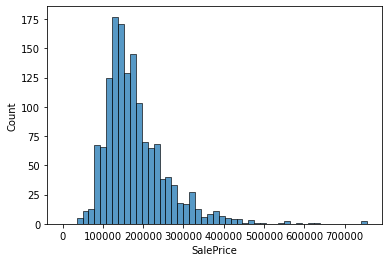

In [15]:
#正規化
sns.histplot(train['SalePrice'])
sns.histplot(np.log(train['SalePrice']))   #参考記事ではdistplot

In [16]:
#モデル構築
#変数がかなり多いため、係数に強力なペナルティをかけるLasso回帰

#学習データとテストデータに分割
train_ = all_data[all_data['WhatIsData']=='Train'].drop(['WhatIsData', 'Id'], axis=1).reset_index(drop=True)
test_ = all_data[all_data['WhatIsData']=='Test'].drop(['WhatIsData', 'SalePrice'], axis=1).reset_index(drop=True)

#学習データ内の分割
train_x = train_.drop('SalePrice', axis=1)
train_y = np.log(train_['SalePrice'])

#テストデータ内の分割
test_id = test_['Id']
test_data = test_.drop('Id', axis=1)

In [17]:
#スケーリング
scaler = StandardScaler()
param_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
cnt = 0
#Lasso回帰モデル
for alpha in param_grid:
    ls = Lasso(alpha=alpha) 
    pipeline = make_pipeline(scaler, ls) 
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.3, random_state=0)
    pipeline.fit(X_train,y_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train)))
    test_rmse = np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test)))
    if cnt == 0:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    elif best_score > test_rmse:
        best_score = test_rmse
        best_estimator = pipeline
        best_param = alpha
    else:
        pass
    cnt = cnt + 1

print('alpha : ' + str(best_param))
print('test score is : ' +str(best_score))

alpha : 0.01
test score is : 0.18072873354655122


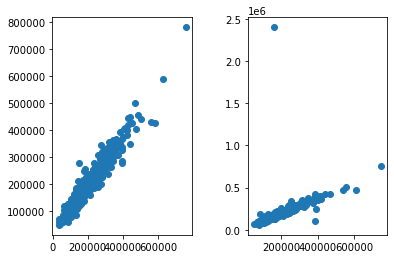

In [18]:
#モデルの検証
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.scatter(np.exp(y_train),np.exp(best_estimator.predict(X_train)))
plt.subplot(122)
plt.scatter(np.exp(y_test),np.exp(best_estimator.predict(X_test)))

In [ ]:
# 提出用データ生成
ls = Lasso(alpha = 0.01)
pipeline = make_pipeline(scaler, ls)
pipeline.fit(train_x,train_y)
test_SalePrice = pd.DataFrame(np.exp(pipeline.predict(test_data)),columns=['SalePrice'])
test_Id = pd.DataFrame(test_id,columns=['Id'])
pd.concat([test_Id, test_SalePrice],axis=1).to_csv('output.csv',index=False)